## <b> Colab <b/>

In [ ]:
#### Install packages
#
#!pip3 install tensorflow-text
#!pip3 install tf-models-official
#!pip3 install transformers
#!pip3 install datasets
#!pip3 install opencc-python-reimplemented
#
#### Access Google Drive
#
#from google.colab import drive
#drive.mount('/content/gdrive')
#
#### Access GCS
#
#from google.colab import auth
#auth.authenticate_user()
#
#### Mount the directories
#
#import os
#
## Mount the data directory
#os.chdir('/content/gdrive/MyDrive/LinuxServer-Bob/Code/Project/Text_Sentimentor/sentimentor')
#os.symlink('/content/gdrive/MyDrive/LinuxServer-Bob/Data', '/data')
#print(f"PWD: {os.getcwd()}")
#
## Mount the tfrecord directory
#gcs_path = "gs://bobscchien-project-data/Text_Sentimentor/datatf"

## <b> Setup <b/>

In [1]:
from utils.initialization import *
from utils.tokenizer import *
from utils.dataset_pipeline import *
from utils.servitization import *
from utils.visualization import *
from models.transformer_bert import *

2021-11-15 16:30:00.651720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-15 16:30:00.651774: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Directory /data exists.
Directory /data/Model_Tensorflow exists.
Directory /data/Model_Pytorch exists.
Directory /data/Text_Tokenizer/vocab exists.
Directory /data/Text_Tokenizer/trained exists.
Directory /data/Text_Sentimentor/dataset exists.
Directory /data/Text_Sentimentor/datatf exists.
Directory /data/Text_Sentimentor/model/savedmodels exists.
Directory /data/Text_Sentimentor/model/checkpoints exists.
Directory /data/Text_Sentimentor/model/logs exists.
Directory /data/Text_Sentimentor/tmp exists.


2021-11-15 16:30:05.467216: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-15 16:30:05.467268: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-15 16:30:05.467304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-11-15 16:30:05.538616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
### Tokenization Method

### Language Pair

lang_pair = ('zh', '')
lang_prefix = f"{lang_pair[0].upper()}_"
inp_lang, tar_lang = lang_pair

### Preprocessor

text_preprocessors = {'inp':zh_preprocess, 'tar':None}

### Global Variables

MAX_LENGTHS = {'inp':256, 'tar':None}

In [4]:
### Definition of Bert Model

bert_names = {'inp':BERT_NAMES[inp_lang]['bert'][0],
              'tar':None}
cache_dirs = {'inp':os.path.join(DIR_MODELTORCH, bert_names['inp']),
              'tar':None}

print(f"Using Pretrained Bert Model: {bert_names}")
print(f"Cache Directory of Model: {cache_dirs}")
print(f"\nMax Length of Text: {MAX_LENGTHS}")

Using Pretrained Bert Model: {'inp': 'bert-base-chinese', 'tar': None}
Cache Directory of Model: {'inp': '/data/Model_Pytorch/bert-base-chinese', 'tar': None}

Max Length of Text: {'inp': 256, 'tar': None}


## <b> 1. Download Dataset <b/>
#### <i> DMSC Dataset <i/>

In [39]:
### Dataset loading & preprocessing

import pandas as pd

dict_rename = {'Comment':'review', 'Star':'label', 'Like':'like'}
dataset = pd.read_csv(os.path.join(DIR_DATA, 'DMSC.csv')).rename(columns=dict_rename)[dict_rename.values()]
print(f"Original Amount of Data:", len(dataset))
 
# Balance the class ( also using log('like'+1)+1 as the weights)
class_distribution = dataset.label.value_counts()
class_minimum = min(class_distribution.min(), 24000)
dataset = pd.concat([df.sample(n=class_minimum, replace=False, weights=np.log1p(df.like)+1, random_state=SEED) 
                     for key, df in dataset.groupby('label')]).drop('like', axis=1).reset_index(drop=True)

# Can also select the data based on the length of the reviews
print('Unbalanced data:\n', class_distribution)
print('Balanced data:\n', dataset.label.value_counts())
print(f"Selected number of data:", len(dataset))

Original Amount of Data: 2125056
Unbalanced data:
 4    641786
5    638106
3    474559
1    190927
2    179678
Name: label, dtype: int64
Balanced data:
 1    24000
2    24000
3    24000
4    24000
5    24000
Name: label, dtype: int64
Selected number of data: 120000


In [40]:
### Preprocessing

raw_texts, raw_labels = dataset.values.T

train_texts = []
for text in tqdm.tqdm(raw_texts):
    # Convert the texts to the tranditional chinese
    text = cc.convert(text)
    # Preprocess the texts
    text = text_preprocessors['inp'](text, py_function=True)
    # Append the results
    train_texts += text
    
train_labels = (raw_labels-1).tolist()

### Data splitting

n_keep = 20000
train_texts, valid_texts, train_labels, valid_labels = train_test_split(train_texts, train_labels, test_size=n_keep, random_state=SEED)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(valid_texts, valid_labels, test_size=0.5, random_state=SEED)

num_samples = len(train_labels)
num_classes = len(set(train_labels))

### Demo

for name, data in zip(['Training', 'Validation', 'Testing'], [train_texts, valid_texts, test_texts]):
    print(f"Number of {name} Data :", len(data))
    
for text, label in zip(train_texts[:5], train_labels):
    print(f'\nReview: {text}')
    print(f'\nLabel : {label}')
    print('\n', '=' * 50)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [00:46<00:00, 2602.70it/s]


Number of Training Data : 100000
Number of Validation Data : 10000
Number of Testing Data : 10000

Review: 一星給李易峰一星給蔣勁夫一星給何老師

Label : 2


Review: 劇情神馬就不說了，不過真好笑，，哈哈哈哈

Label : 3


Review: 懂的人自然會懂和你【一起走過小時代的人】一起去看

Label : 4


Review: 為什麼我覺得一般般的電影分數都還不錯、、、

Label : 2


Review: 近期看過最好看的動畫

Label : 4



## <b> 2. Setup Tokenizer & Dataset Pipeline <b/>

In [41]:
tokenizers = tf.Module()
tokenizers.inp = AutoTokenizer.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp'], do_lower_case=True)

### Parameters

tokenizer_params = {
    'inp':{'add_special_tokens':True, 'padding':True, 'truncation':True, 'max_length':MAX_LENGTHS['inp'], 
           'return_attention_mask':True, 'return_token_type_ids':False},
    'tar':None
}

### Vocab Sizes

inp_vocab_size = tokenizers.inp.vocab_size

print(f'{inp_lang} Vocabulary Size :', inp_vocab_size)

zh Vocabulary Size : 21128


In [70]:
import functools

### Save TFRecord

def serialize_example(text, label):
    """
    Creates a tf.train.Example message ready to be written to a file.
    """
    # Create a dictionary mapping the feature name to the tf.train.Example-compatible data type.
    # The inputs here are Hugging Face tokenizer objects
    feature = {
        'inp_input_ids':int64_feature(text.ids),
        'inp_attention_mask':int64_feature(text.attention_mask),
        'labels':int64_feature([label]),
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def saveTFRecord(name, dir_tfrecord, dataset, shard=1):    
    texts, labels = dataset
    
    amount = len(labels)
    sample = amount//shard 
    
    count = 0
    for n in tqdm.tqdm(range(shard)):
        # Write the `tf.train.Example` observations to the file.
        filename = os.path.join(dir_tfrecord, f'{name}{n}.tfrecord')
        
        # The last file will be slightly bigger than the other files
        if amount - (count+sample) < sample:
            sample += amount - (count + sample)

        with tf.io.TFRecordWriter(filename) as writer:
            for i in range(count, count+sample):
                example = serialize_example(texts[i], labels[i])
                writer.write(example)
        
        count += sample
        
### Load TFRecord

def parse_example(example_proto, max_lengths, labeled=True):
    # Create a dictionary describing the features.
    feature_description = {
        'inp_input_ids':tf.io.FixedLenFeature([max_lengths['inp']], tf.int64),
        'inp_attention_mask':tf.io.FixedLenFeature([max_lengths['inp']], tf.int64),
        'labels':tf.io.FixedLenFeature([1], tf.int64)
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # tf.Example only supports tf.int64, but the TPU only supports tf.int32, so cast all int64 to int32.
    for name in list(example.keys()):
        tmp = example[name]
        if tmp.dtype == tf.int64:
            tmp = tf.cast(tmp, tf.int32)
        example[name] = tmp
        
    texts = (example['inp_input_ids'], example['inp_attention_mask'])
    if labeled:
        labels = example['labels']
        return texts, labels
    return texts

def loadTFRecord(filename, dir_tfrecord, max_lengths, batch_size=64, shuffle_size=None, cache=True, labeled=True):
    dataset = tf.data.Dataset.list_files(os.path.join(dir_tfrecord, f'{filename}*.tfrecord'))
    dataset = dataset.interleave(tf.data.TFRecordDataset, num_parallel_calls=AUTOTUNE, deterministic=False,
                                 cycle_length=AUTOTUNE, block_length=1)
    dataset = dataset.map(functools.partial(parse_example, max_lengths=max_lengths, labeled=labeled), 
                          num_parallel_calls=AUTOTUNE, deterministic=None)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_size:
        dataset = dataset.shuffle(shuffle_size)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset


In [71]:
reprocess = True

if reprocess:
    
    #### Bert Tokenization: can only accept str, List[str] or List[List[str]]

#    train_encodings = tokenizers.inp(train_texts, **tokenizer_params['inp'])
#    valid_encodings = tokenizers.inp(valid_texts, **tokenizer_params['inp'])
    test_encodings = [tokenizers.inp(test_texts, **tokenizer_params['inp']),
                      test_labels]
    
    ### Save the tokens to tfrecord files

#    saveTFRecord(lang_prefix+"train", DIR_TFRECORD, train_encodings, shard=10)
#    saveTFRecord(lang_prefix+"valid", DIR_TFRECORD, valid_encodings, shard=1)
    saveTFRecord(lang_prefix+"test", DIR_TFRECORD, test_encodings, shard=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


In [72]:
BUFFER_SIZE = 2**13
BATCH_SIZE = 64

#train_batches = loadTFRecord(lang_prefix+'train', DIR_TFRECORD, MAX_LENGTHS, BATCH_SIZE, BUFFER_SIZE)
#valid_batches = loadTFRecord(lang_prefix+'valid', DIR_TFRECORD, MAX_LENGTHS, BATCH_SIZE)
test_batches = loadTFRecord(lang_prefix+'test', DIR_TFRECORD, MAX_LENGTHS, BATCH_SIZE, cache=False)

for demo in test_batches.take(1):
    print(demo)

2021-11-15 19:31:12.450630: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: inp_attention_mask.  Can't parse serialized Example.
2021-11-15 19:31:12.450678: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: inp_input_ids.  Can't parse serialized Example.
2021-11-15 19:31:12.450703: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: inp_attention_mask.  Can't parse serialized Example.
2021-11-15 19:31:12.450717: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: inp_input_ids.  Can't parse serialized Example.
2021-11-15 19:31:12.450735: W tensorflow/core/framework/op_kernel.cc:1692] OP_REQUIRES failed at example_parsing_ops.cc:94 : Invalid argument: Key: inp_attention_mask.  Can't parse serialized Example.
2021-

InvalidArgumentError: Key: inp_attention_mask.  Can't parse serialized Example.
	 [[{{node ParseSingleExample/ParseExample/ParseExampleV2}}]] [Op:IteratorGetNext]

## <b> 3. Configure Training <b/>

### <b> Hyperparameters <b/>

In [9]:
### Configure pretrained model

configs = {'inp':AutoConfig.from_pretrained(bert_names['inp'], cache_dir=cache_dirs['inp']),
           'tar':None}
pprint(configs)

### Configure training process

EPOCHS = 100
EARLYSTOP = 5

init_lr = 3e-5

### Configure downstream model structure ( Mark the unused hyperparameters )

num_layers = 1
num_projection_layers = 1
#embed_pos = True
embed_dim = 256
dense_dim = 512
num_heads = 8
dropout = 0.2
activation, activation_name = tf.nn.gelu, 'gelu'

nn_units = 64
all_tune = False
use_lstm = False

### Other configuration

#teacher = 100

{'inp': BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 21128
}
,
 'tar': None}


### <b> Loss & Metrics & Optimizer <b/>

In [10]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy_function = tf.keras.metrics.SparseCategoricalAccuracy()

metrics = [accuracy_function] 

In [11]:
steps_per_epoch = num_samples//BATCH_SIZE+1
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

optimizer = official.nlp.optimization.create_optimizer(init_lr=init_lr,
                                                       num_train_steps=num_train_steps,
                                                       num_warmup_steps=num_warmup_steps,
                                                       optimizer_type='adamw')
print(f'warmup_steps: {num_warmup_steps}')

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


warmup_steps: 18660


### <b> Model <b/>

Some layers from the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


ZH_TransformerEncoder_bert-base-chinese
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 102267648   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
embedding_projector (EmbeddingP (None, None, 256)    2

None

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


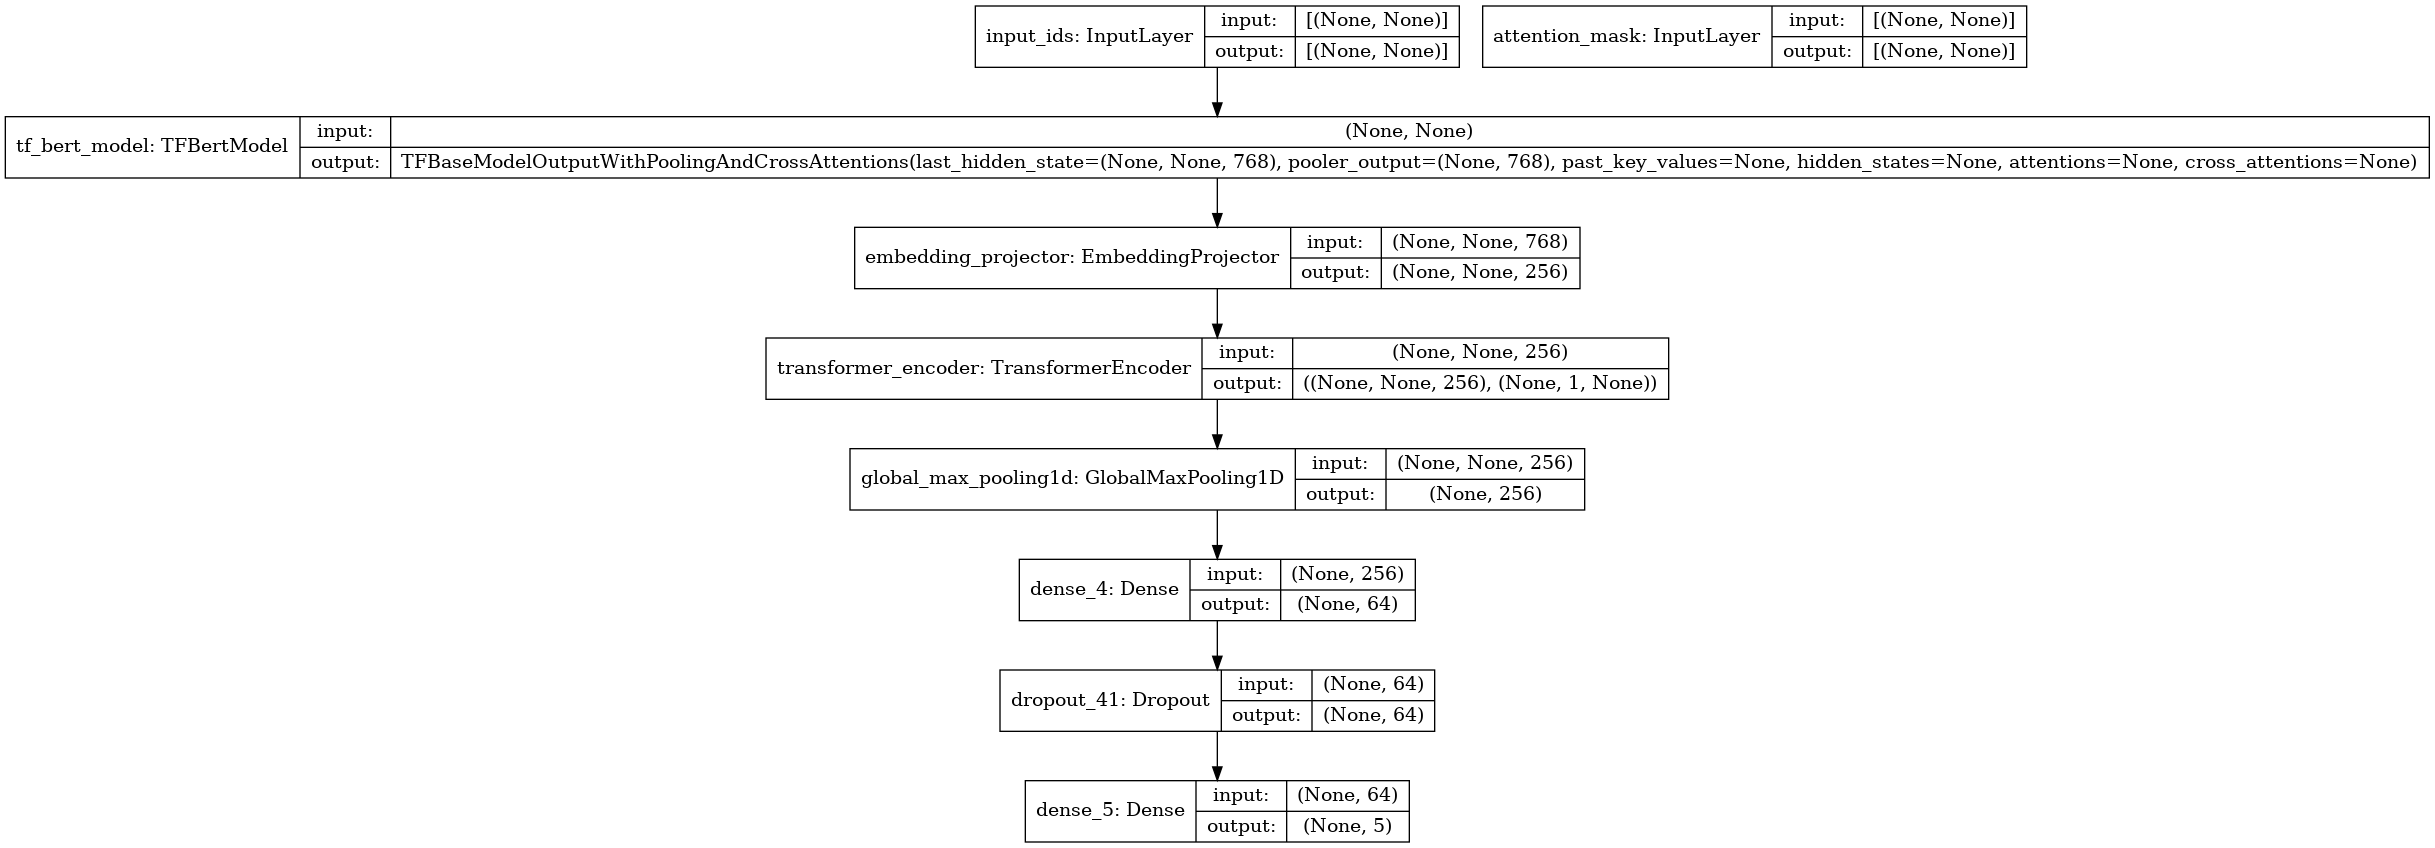

In [12]:
# Plot the model
model_name = lang_prefix+f"TransformerEncoder{'BiLSTM' if use_lstm else ''}_{bert_names['inp']}"
model = BertTransformerEncoder(bert_names=bert_names, 
                               configs=configs, 
                               cache_dirs=cache_dirs, 
                               all_tune=all_tune, 
                               num_projection_layers=num_projection_layers, 
                               use_lstm=use_lstm, 
                               nn_units=nn_units, 
                               num_layers=num_layers, 
                               embed_dim=embed_dim, 
                               num_heads=num_heads,
                               dense_dim=dense_dim,
                               num_classes=num_classes,
                               activation=activation, 
                               dropout=dropout)

print(model_name)
display(model.build_graph().summary())
display(tf.keras.utils.plot_model(model.build_graph(), show_shapes=True, expand_nested=True))

## <b> 4. Training and checkpointing <b/>

### <b> Checkpoint <b/>

In [13]:
# 方便比較不同實驗/ 不同超參數設定的結果
run_id  = f"{num_layers}layers_{num_projection_layers}projlayers_{nn_units}nnunits_{num_heads}heads_{embed_dim}embedding_{dense_dim}hidden"
run_id += f"_{dropout}dropout_{activation_name}_{num_warmup_steps}warmup_{optimizer._name}_{'all' if all_tune else 'part'}finetune"
run_id += f"_{BATCH_SIZE}batchsize_{BUFFER_SIZE}shuffle_{num_samples}samples"
print('run_id:', run_id, '\n')

# 設定存檔路徑
checkpoint_path = os.path.join(DIR_CHECKPOINT, model_name+'_'+run_id)
log_dir = os.path.join(DIR_LOG, model_name+'_'+run_id)

# 設定回調函數
es_metric = 'val_loss'

checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor=es_metric, save_weights_only=True, save_best_only=True, verbose=1, filepath=checkpoint_path)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor=es_metric, patience=EARLYSTOP, restore_best_weights=True, verbose=1)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

callbacks = [tensorboard, checkpoint, earlystopping]

# 回覆存檔點
try:
    model.load_weights(checkpoint_path)
    print(f'Restore the checkpoint at {checkpoint_path}')
except:
    print("There is no existed checkpoint ... Start from the beginning.\n")

run_id: 1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_18660warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_119405samples 

There is no existed checkpoint ... Start from the beginning.



2021-11-14 13:01:36.952721: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-14 13:01:36.952928: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-14 13:01:36.955488: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### <b> Training <b/>

In [ ]:
%%time

model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
history = model.fit(train_batches, validation_data=valid_batches, 
                    epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

Epoch 1/100


2021-11-14 13:01:52.407628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


   1/1866 [..............................] - ETA: 17:12:11 - loss: 3.2741 - sparse_categorical_accuracy: 0.1562

2021-11-14 13:02:12.332073: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-14 13:02:12.332114: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   2/1866 [..............................] - ETA: 8:52:31 - loss: 3.1401 - sparse_categorical_accuracy: 0.1953 

2021-11-14 13:02:27.623128: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-14 13:02:27.635193: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-14 13:02:27.650880: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /data/Text_Sentimentor/model/logs/ZH_TransformerEncoder_bert-base-chinese_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_18660warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_119405samples/train/plugins/profile/2021_11_14_13_02_27

2021-11-14 13:02:27.659616: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /data/Text_Sentimentor/model/logs/ZH_TransformerEncoder_bert-base-chinese_1layers_1projlayers_64nnunits_8heads_256embedding_512hidden_0.2dropout_gelu_18660warmup_AdamWeightDecay_partfinetune_64batchsize_8192shuffle_119405samples/train/plugins/profile/2021_11_

 988/1866 [==============>...............] - ETA: 3:35:40 - loss: 2.4464 - sparse_categorical_accuracy: 0.2142

### <b> Evaluation <b/>

In [ ]:
%%time

loss, accuracy = model.evaluate(test_batches)

score = f"accuracy-{accuracy:.6f}-{dataset_dir[dataset_dir.rfind('/')+1:]}"
score

## <b> 5. Model Export & Pipeline Build <b/>

In [41]:
class HF2TFModelExporter(tf.Module):
    """ 
    Save the fine-tuned Hugging Face model with detail information, 
    and should be modified based on the model's inputs.    
    """
    def __init__(self, model, bert_names, config_detail, num_classes, inp_lang='', tar_lang=''):
        self.model = model
        self.num_classes = num_classes
        self.config_detail = tf.Variable(config_detail)
        
        self.inp_bert = tf.Variable(bert_names['inp'] or '')        
        self.tar_bert = tf.Variable(bert_names['tar'] or '')        
        self.inp_lang = tf.Variable(inp_lang)
        self.tar_lang = tf.Variable(tar_lang)     

    # Notice: the input should be encoded as token_ids and masks, 
    # and the signature need to be adjusted based on the number of masks
    @tf.function(input_signature=[[tf.TensorSpec(shape=[None, None], dtype=tf.int32),
                                   tf.TensorSpec(shape=[None, None], dtype=tf.int32)]])
    def __call__(self, inputs, return_prob=True):        
        outputs = self.model(inputs, training=False)
        
        # Multiclass Problem
        if self.num_classes <= 2:
            outputs = tf.nn.sigmoid(outputs)
        else:
            outputs = tf.nn.softmax(outputs)
            if not return_prob:
                outputs = tf.math.argmax(outputs, axis=-1) + 1

        return outputs

In [43]:
### Create and save the predictor

config_detail = f"{model_name}_{score}_{run_id}"
predictor = HF2TFModelExporter(model, bert_names, config_detail=config_detail, num_classes=num_classes, inp_lang=inp_lang)
predictor_dir = os.path.join(DIR_MODEL, f"{model_name}_{score}")
tf.saved_model.save(predictor, export_dir=predictor_dir)

### Reload the pipeline to verify the result

model_dir = predictor_dir
pretrain_dir = DIR_MODELTORCH
pipeline = HF2TFClassifierPipeline(model_dir, pretrain_dir, text_preprocessors, max_length=MAX_LENGTHS['inp'])

2021-11-14 12:49:40.613500: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


NameError: name 'AutoConfig' is not defined

## <b> 6. Run Inference <b/>

In [75]:
sentences = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'this is a bad test', 
    'and happy one is here to be classified',
    'I broke up with my...cat, help me :(:(:(',
    'movie data seems to be not enough',
    'it is definitely not bad'
]

results = pipeline(sentences)
results_for_printing = [f"Input: {sentences[n]:<50} => score: {results[n][0]:.6f}"
                        for n, text in enumerate(sentences)]

print(*results_for_printing, sep='\n')

Input: this is such an amazing movie!                     => score: 0.198779
Input: The movie was great!                               => score: 0.394043
Input: The movie was meh.                                 => score: 0.277968
Input: The movie was okish.                               => score: 0.264516
Input: The movie was terrible...                          => score: 0.172645
Input: this is a bad test                                 => score: 0.264395
Input: and happy one is here to be classified             => score: 0.445607
Input: I broke up with my...cat, help me :(:(:(           => score: 0.117212
Input: movie data seems to be not enough                  => score: 0.223223
Input: it is definitely not bad                           => score: 0.326945
